## TCC - Marryele Moniê
Especialização em Ciências de Dados e Big Data - 2019
---




Importação de bibliotecas para usar nos códigos


In [1]:

!pip install ipywidgets
!pip3 install graphviz
!pip3 install pydot

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import svm

from matplotlib import pyplot as plt

import pydot
import graphviz
from sklearn import tree

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from sklearn.naive_bayes import GaussianNB

from matplotlib import pyplot as plt

import pydot
import graphviz
from sklearn import tree

Carregando dados


In [4]:
orders = pd.read_csv('https://raw.githubusercontent.com/Marryele/tcc_puc/main/olist_orders_dataset.csv')
 
customers = pd.read_csv("https://raw.githubusercontent.com/Marryele/tcc_puc/main/olist_customers_dataset.csv") 

order_items = pd.read_csv('https://raw.githubusercontent.com/Marryele/tcc_puc/main/olist_order_items_dataset.csv') 

products = pd.read_csv('https://raw.githubusercontent.com/Marryele/tcc_puc/main/olist_products_dataset.csv')  

order_review = pd.read_csv('https://raw.githubusercontent.com/Marryele/tcc_puc/main/olist_order_reviews_dataset.csv') 

In [5]:
# converting to datetime para fazer a diferença de dias de atraso posteriormente
orders['order_purchase_timestamp'] = pd.to_datetime(orders.order_purchase_timestamp).dt.date
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date).dt.date  
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date).dt.date  


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [7]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [9]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [10]:
order_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


Faço o groupby com a função sum para somar o valor dos produtos e do frete para cada order_id e produt_id dos pedidos. Quero agregar na tabela principal essas informações de valores e frete

In [11]:
orders = orders.merge((order_items.groupby(['order_id','product_id' ]).sum()), how= 'left', left_on= 'order_id', right_on= 'order_id')  
orders = orders.rename( columns= {'price': 'order_products_value', 'freight_value': 'order_freight_value'} )
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,order_products_value,order_freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10,2017-10-18,1.0,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07,2018-08-13,1.0,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17,2018-09-04,1.0,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02,2017-12-15,1.0,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16,2018-02-26,1.0,19.90,8.72


Faço merge com a tabela custumers para trazer as informações do cliente, como o customer_unique_id e cidade e estado

In [12]:
orders = orders.merge(customers, how = 'left', left_on= 'customer_id', right_on='customer_id') 

O que interessa no order_items é o product_id, removo as colunas que não interessam e deixo apenas order_id e product_id no dataframe order_items


In [13]:
orders = orders.merge(order_items.drop(labels=[ 'order_item_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'], axis= 1).drop_duplicates(), how= 'left',left_on ='order_id',right_on = 'order_id')

In [14]:
#poderia usar a categoria do produto de maior preço comprado, 
#é ordenar pelo maior e dar um drop duplicate keep first

Faço merge com a tabela products e consifo informações de categoria do produto, quantas fotos ele tem, qual o tamanho da descrição, etc.

In [15]:
orders = orders.merge(products, how='left', left_on='product_id', right_on='product_id')  
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,order_products_value,order_freight_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10,2017-10-18,1.0,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,87285b34884572647811a353c7ac498a,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07,2018-08-13,1.0,118.70,22.76,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,595fac2a385ac33a80bd5114aec74eb8,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17,2018-09-04,1.0,159.90,19.22,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,aa4383b373c6aca5d8797843e5594415,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02,2017-12-15,1.0,45.00,27.20,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16,2018-02-26,1.0,19.90,8.72,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,65266b2da20d04dbe00c5c2d3bb7859e,papelaria,38.0,316.0,4.0,250.0,51.0,15.0,15.0


Vou contar a quantidade de order_id por customer_unique_id assim tereia a quantidade de compras que o consumidor já fez



In [16]:
qtd_pedidos = orders[['order_id', 'customer_id','customer_unique_id']].groupby('customer_unique_id', as_index= False).count()

In [17]:
qtd_pedidos.head()

,customer_unique_id,order_id,customer_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1
2,0000f46a3911fa3c0805444483337064,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,1
4,0004aac84e0df4da2b147fca70cf8255,1,1


In [18]:
qtd_pedidos['order_id'].value_counts()

1     90226
4      2569
2      2467
9       248
5       221
3       162
16       62
10       38
6        36
8        16
36        8
25        8
13        6
17        6
11        6
7         3
49        3
37        2
12        1
14        1
15        1
18        1
19        1
20        1
23        1
26        1
64        1
Name: order_id, dtype: int64

Faço merge com a tabela Orders para trazer essa informação de quantidade de pedidos

In [19]:
orders = orders.merge(qtd_pedidos, how='left', left_on='customer_unique_id', right_on='customer_unique_id', suffixes=['','_qtd'])

In [20]:
orders.shape

(112162, 26)

Fiz uma ordenação das notas pela mais recente até a mais antiga, removi duplicadas a partir do order_id e mantive a primeira que é a review_score mais recente

In [21]:
order_review = order_review.sort_values('review_creation_date', ascending= False).drop_duplicates(subset= 'order_id', keep='first')

In [22]:
orders = orders.merge(order_review, how= 'left', left_on='order_id',right_on='order_id')  

In [23]:
orders.shape

(112162, 32)

In [24]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'order_products_value', 'order_freight_value',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'product_id', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'order_id_qtd',
       'customer_id_qtd', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

##4 -  exploração dos dados**


In [25]:
orders['order_status'].value_counts()

delivered      109070
shipped          1170
canceled          637
unavailable       612
invoiced          350
processing        316
created             5
approved            2
Name: order_status, dtype: int64

In [26]:
orders = orders.loc[orders['order_status'] == 'delivered']

In [27]:
orders.shape

(109070, 32)

Calculando a diferença entre a data da entrega e a data esperada da entrega

In [28]:
orders['atrasoentrega'] = (orders.order_delivered_customer_date - orders.order_estimated_delivery_date)

In [29]:
orders['atrasoentrega'] = pd.to_numeric(orders['atrasoentrega'].dt.days, downcast='integer')

In [30]:
orders['prazo_entrega'] = (orders.order_estimated_delivery_date - orders.order_purchase_timestamp)
orders['prazo_entrega'] = pd.to_numeric(orders['prazo_entrega'].dt.days, downcast='integer')

Algumas variáveis categóricas como customer_state e product_category_name podem agregar no modelo por isso tranformei ela em números para usarmos

In [38]:
orders['product_category_name'].value_counts()

cama_mesa_banho                                  12086
beleza_saude                                      9321
esporte_lazer                                     8047
moveis_decoracao                                  7779
informatica_acessorios                            7223
                                                 ...  
portateis_cozinha_e_preparadores_de_alimentos       13
cds_dvds_musicais                                   12
fashion_roupa_infanto_juvenil                        9
pc_gamer                                             8
seguros_e_servicos                                   2
Name: product_category_name, Length: 73, dtype: int64

In [39]:
orders['customer_state'].value_counts()

SP    46145
RJ    13928
MG    12842
RS     6050
PR     5484
SC     3969
BA     3644
DF     2372
GO     2233
ES     2225
PE     1724
CE     1407
MT     1063
PA     1062
MA      815
MS      776
PB      564
RN      529
PI      508
AL      424
SE      356
TO      311
RO      282
AM      157
AC       83
AP       76
RR       41
Name: customer_state, dtype: int64

In [40]:
orders['customer_state'] = orders['customer_state'].astype('category')
orders['product_category_name'] = orders['product_category_name'].astype('category')

In [41]:
categoricas = orders.select_dtypes(['category']).columns

In [42]:
orders[categoricas] = orders[categoricas].apply(lambda x: x.cat.codes)

In [43]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,order_products_value,order_freight_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_id_qtd,customer_id_qtd,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,atrasoentrega,prazo_entrega
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10,2017-10-18,1.0,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,25,87285b34884572647811a353c7ac498a,72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,2,2,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,-8.0,16
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07,2018-08-13,1.0,118.70,22.76,af07308b275d755c9edb36a90c618231,47813,barreiras,4,595fac2a385ac33a80bd5114aec74eb8,62,29.0,178.0,1.0,400.0,19.0,13.0,19.0,1,1,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,-6.0,20
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17,2018-09-04,1.0,159.90,19.22,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,8,aa4383b373c6aca5d8797843e5594415,8,46.0,232.0,1.0,420.0,24.0,19.0,21.0,1,1,e73b67b67587f7644d5bd1a52deb1b01,5,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,-18.0,27
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02,2017-12-15,1.0,45.00,27.20,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,19,d0b61bfb1de832b15ba9d266ca96e5b0,63,59.0,468.0,3.0,450.0,30.0,10.0,20.0,1,1,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58,-13.0,27
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16,2018-02-26,1.0,19.90,8.72,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,25,65266b2da20d04dbe00c5c2d3bb7859e,59,38.0,316.0,4.0,250.0,51.0,15.0,15.0,1,1,e50934924e227544ba8246aeb3770dd4,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51,-10.0,13


Ordenar a product_value do maior para o menor e dar um drop_duplicate pelo order_id para manter o maior (keep first) ou manter o pedido de menor valor (keep last). Analisar os dois mas remover os ORDER_ID DUPLICADAS

In [44]:
orders['order_id'].value_counts()

ca3625898fbd48669d50701aba51cd5f    64
ad850e69fce9a512ada84086651a2e7d    49
77df84f9195be22a4e9cb72ca9e8b4c2    49
7d8f5bfd5aff648220374a2df62e84d5    49
aa0b425987bdeae4a29c616a2bc3a08a    36
                                    ..
1b2db2aab76c9c5abd0f6538ca507016     1
08e4ca5f437f69407fb01cabd2d7a0b8     1
244eca4c9c8dd0dd793f6ea85d5ddc7b     1
e4d30fd714b8811d4c77924ca7e95c42     1
b7d7bac557fdaf041e274d8043d9c588     1
Name: order_id, Length: 96478, dtype: int64

In [45]:
orders = orders.sort_values('order_products_value') #do menor para o maior

In [46]:
orders_1 = orders.drop_duplicates(subset= 'order_id', keep= 'last') #deixando o pedido de maior valor

In [47]:
orders_2 = orders.drop_duplicates(subset= 'order_id', keep= 'first') #deixando o pedido de menor valor

In [48]:
dados = orders_1[['order_products_value','order_freight_value','order_id_qtd','product_category_name',
                  'customer_state','product_description_lenght', 
                 'product_photos_qty', 'review_score','atrasoentrega','prazo_entrega']]

In [49]:
dados.shape

(96478, 10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8242f7bf60>]],
      dtype=object)

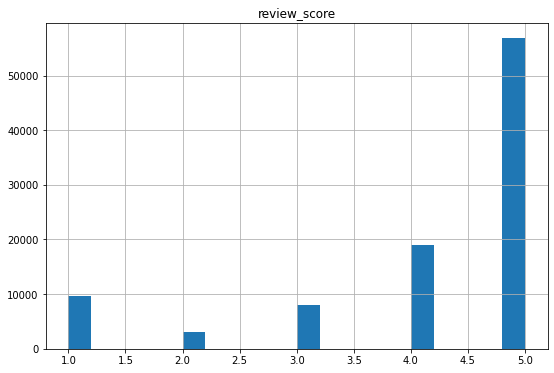

In [50]:
dados.hist(column='review_score',    # Coluna a ser plotada
                   figsize=(9,6),   # Tamanho do gráfico
                   bins=20)  

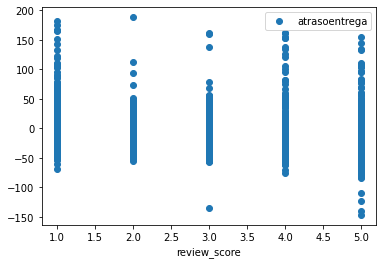

In [51]:
dados.plot(x = 'review_score', y= 'atrasoentrega', style='o')

In [52]:
dados.corr()

,order_products_value,order_freight_value,order_id_qtd,product_category_name,customer_state,product_description_lenght,product_photos_qty,review_score,atrasoentrega,prazo_entrega
order_products_value,1.000000,0.409852,-0.016169,0.010248,-0.043516,0.194047,0.038796,-0.027491,-0.009877,0.074917
order_freight_value,0.409852,1.000000,0.002179,0.028829,-0.191290,0.080877,-0.000436,-0.071683,-0.041506,0.244375
order_id_qtd,-0.016169,0.002179,1.000000,-0.013848,0.010988,-0.044648,-0.025870,-0.069768,-0.044081,0.023037
product_category_name,0.010248,0.028829,-0.013848,1.000000,-0.009513,-0.055831,0.081354,0.002768,-0.016682,0.027535
customer_state,-0.043516,-0.191290,0.010988,-0.009513,1.000000,-0.024596,-0.010346,0.051458,0.037771,-0.348924
product_description_lenght,0.194047,0.080877,-0.044648,-0.055831,-0.024596,1.000000,0.120427,0.013154,0.002284,0.000915
product_photos_qty,0.038796,-0.000436,-0.025870,0.081354,-0.010346,0.120427,1.000000,0.013682,0.003674,-0.034100
review_score,-0.027491,-0.071683,-0.069768,0.002768,0.051458,0.013154,0.013682,1.000000,-0.269421,-0.052185
atrasoentrega,-0.009877,-0.041506,-0.044081,-0.016682,0.037771,0.002284,0.003674,-0.269421,1.000000,-0.499477
prazo_entrega,0.074917,0.244375,0.023037,0.027535,-0.348924,0.000915,-0.034100,-0.052185,-0.499477,1.000000


In [53]:
dados = dados.loc[(dados['atrasoentrega'] < (dados['atrasoentrega'].mean()+(2*dados['atrasoentrega'].std()))) & 
                  (dados['atrasoentrega'] > (dados['atrasoentrega'].mean()-(2*dados['atrasoentrega'].std())))]

In [54]:
dados.shape

(92173, 10)

In [55]:
dados['review_score'].value_counts()

5    55531
4    18501
1     7783
3     7656
2     2702
Name: review_score, dtype: int64

In [56]:
a_trocar = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1,
    5 : 1
}
dados.review_score = dados.review_score.map(a_trocar)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [57]:
dados['review_score'].value_counts()

1    74032
0    18141
Name: review_score, dtype: int64

In [58]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92173 entries, 80202 to 15075
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   order_products_value        92173 non-null  float64
 1   order_freight_value         92173 non-null  float64
 2   order_id_qtd                92173 non-null  int64  
 3   product_category_name       92173 non-null  int8   
 4   customer_state              92173 non-null  int8   
 5   product_description_lenght  90871 non-null  float64
 6   product_photos_qty          90871 non-null  float64
 7   review_score                92173 non-null  int64  
 8   atrasoentrega               92173 non-null  float64
 9   prazo_entrega               92173 non-null  int16  
dtypes: float64(5), int16(1), int64(2), int8(2)
memory usage: 6.0 MB


In [59]:
dados = dados.fillna(0)

In [60]:
dados.head()

,order_products_value,order_freight_value,order_id_qtd,product_category_name,customer_state,product_description_lenght,product_photos_qty,review_score,atrasoentrega,prazo_entrega
80202,0.85,18.23,1,21,25,1041.0,5.0,1,-10.0,23
93832,0.85,18.23,1,21,18,1041.0,5.0,1,-14.0,24
107698,2.20,7.39,1,11,25,398.0,2.0,1,-5.0,9
13143,2.29,7.78,1,59,25,326.0,1.0,1,-8.0,13
84149,2.90,8.72,3,63,17,1392.0,1.0,1,-28.0,39


##Separando bases treino e teste

In [61]:
x = dados[['order_freight_value','order_products_value','atrasoentrega','product_photos_qty','product_description_lenght',
                'customer_state','prazo_entrega', 'product_category_name','order_id_qtd']]
y = dados['review_score']

SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))


Treinaremos com 69129 elementos e testaremos com 23044 elementos


In [62]:
dummy_stratified = DummyClassifier()
dummy_stratified.fit(treino_x, treino_y)
acuracia = dummy_stratified.score(teste_x, teste_y) * 100

print("A acurácia do dummy stratified foi %.2f%%" % acuracia)

A acurácia do dummy stratified foi 68.25%


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


## Regrassão SUPORT VECTOR MACHINE SVM

In [ ]:
modelo = svm.SVC()
modelo.fit(treino_x, treino_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

A acurácia foi 80.32%


## Regressão Linear

In [ ]:
modelo = LinearSVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

A acurácia foi 80.11%


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
modelo.coef_

array([[-8.21505760e-04, -5.52862523e-04, -2.94538250e-02,
         2.94484223e-03, -5.69351744e-05,  1.63625734e-03,
        -1.39192073e-02,  4.00474006e-03, -6.02835209e-02]])

(array([[ 4535.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 18509.],
        [  170.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 22874.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

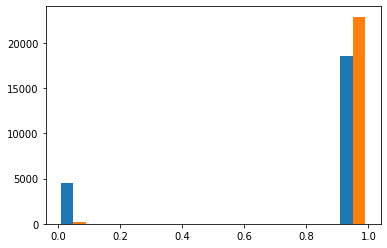

In [ ]:
plt.hist([teste_y, previsoes])

In [ ]:
print(metrics.classification_report(teste_y,previsoes))

              precision    recall  f1-score   support

           0       0.36      0.01      0.03      4535
           1       0.80      0.99      0.89     18509

    accuracy                           0.80     23044
   macro avg       0.58      0.50      0.46     23044
weighted avg       0.72      0.80      0.72     23044



##Regressão

In [ ]:
SEED = 5
np.random.seed(SEED)
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)

scaler = StandardScaler()
scaler.fit(raw_treino_x)
treino_x = scaler.transform(raw_treino_x)
teste_x = scaler.transform(raw_teste_x)

modelo = SVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

A acurácia foi 81.60%


(array([[ 4535.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 18509.],
        [  517.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 22527.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

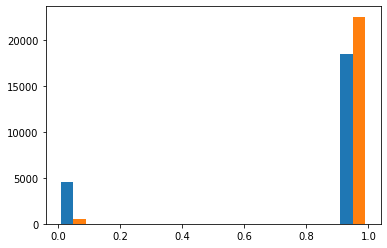

In [ ]:
plt.hist([teste_y, previsoes])

##Random forest regressor

In [ ]:
forest_reg = RandomForestRegressor(criterion= 'mse') # n_estimators= 50 ,max_depth=10, bootstrap= True
forest_reg.fit(treino_x, treino_y)

predictions = forest_reg.predict(teste_x)
forest_mse = mean_squared_error(teste_y, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

errors = abs(predictions - teste_y)
MSE=round(np.mean(errors),2)
MAPE=100*(errors/teste_y)
accuracy=round (100 - np.mean(MAPE),2)

print("A acurácia foi %.2f%%" % accuracy)


A acurácia foi -inf%


In [ ]:
forest_rmse

0.3893397107107334

##Naive Bayes

In [63]:
gnb = GaussianNB()
y_pred = gnb.fit(treino_x,treino_y).predict(teste_x)

ac = gnb.score(teste_x, teste_y)

print("\nAcurácia do modelo: {0:.2f}%\n".format(100*ac))


Acurácia do modelo: 78.78%



In [64]:
print(metrics.classification_report(teste_y,y_pred))

              precision    recall  f1-score   support

           0       0.39      0.13      0.20      4535
           1       0.82      0.95      0.88     18509

    accuracy                           0.79     23044
   macro avg       0.60      0.54      0.54     23044
weighted avg       0.73      0.79      0.74     23044



(array([[ 4535.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 18509.],
        [ 1566.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 21478.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

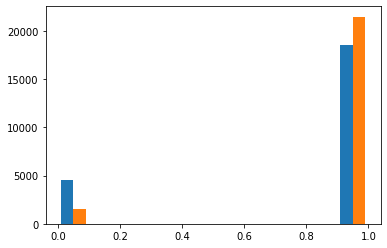

In [65]:
plt.hist([teste_y, y_pred])

##Árvore de decisão

In [ ]:
modelo = DecisionTreeClassifier(max_depth=3)
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

In [ ]:
print(metrics.classification_report(teste_y,previsoes))

(array([[ 4535.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 18509.],
        [  613.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 22431.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

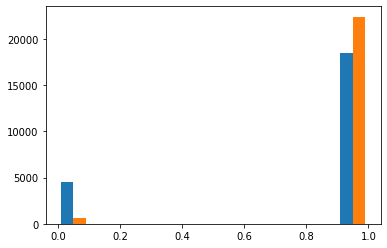

In [68]:
plt.hist([teste_y, previsoes])

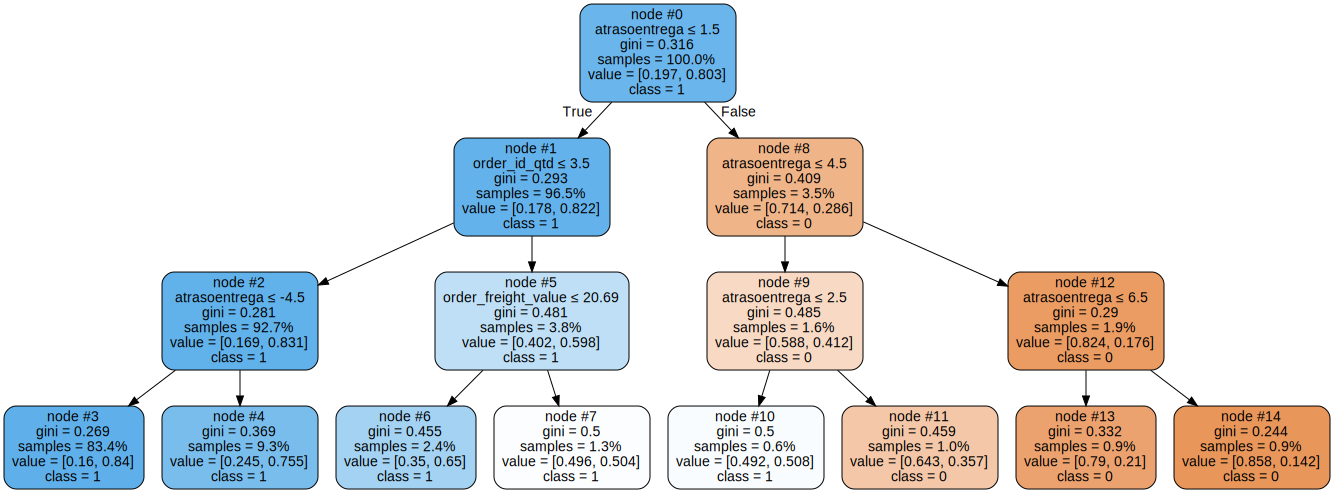

In [69]:
dot_data = tree.export_graphviz( 
         modelo, 
         out_file=None,
         feature_names=['order_freight_value','order_products_value','atrasoentrega','product_photos_qty','product_description_lenght',
                'customer_state','prazo_entrega','product_category_name','order_id_qtd'],
         class_names=['0','1'],  
         filled=True, rounded=True,
         proportion=True,
         node_ids=True,
         rotate=False,
         label='all',
         special_characters=True
        )  
graph = graphviz.Source(dot_data)  
graph